# Exploratory Data Analysis Starter

## Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---

## Loading data with Pandas

We need to load `client_data.csv` and `price_data.csv` into individual dataframes so that we can work with them in Python. For this notebook and all further notebooks, it will be assumed that the CSV files will the placed in the same file location as the notebook. If they are not, please adjust the directory within the `read_csv` method accordingly.

In [2]:
client_df = pd.read_csv('./data/client_data.csv')
price_df = pd.read_csv('./data/price_data.csv')

You can view the first 3 rows of a dataframe using the `head` method. Similarly, if you wanted to see the last 3, you can use `tail(3)`

In [3]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [20]:
client_df['num_years_antig'].value_counts()

num_years_antig
6     4769
4     3982
3     2433
5     2317
7      509
11     185
12     110
8      103
9       92
10      81
13      13
2       11
1        1
Name: count, dtype: int64

In [4]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


---

## Descriptive statistics of data

### Data types


In [5]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [6]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


### Statistics

Now let's look at some statistics about the datasets. We can do this by using the `describe()` method.

In [7]:
client_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


In [8]:
price_df.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


---

## Data visualization


In [9]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

The first function `plot_stacked_bars` is used to plot a stacked bar chart. 

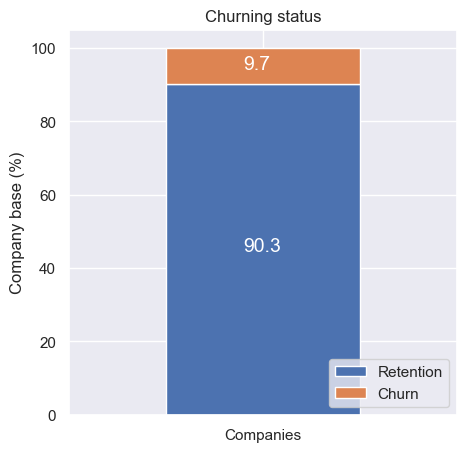

In [10]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

The second function `annotate_bars` is used by the first function, but the third function `plot_distribution` helps you to plot the distribution of a numeric column. An example of how it can be used is given below:

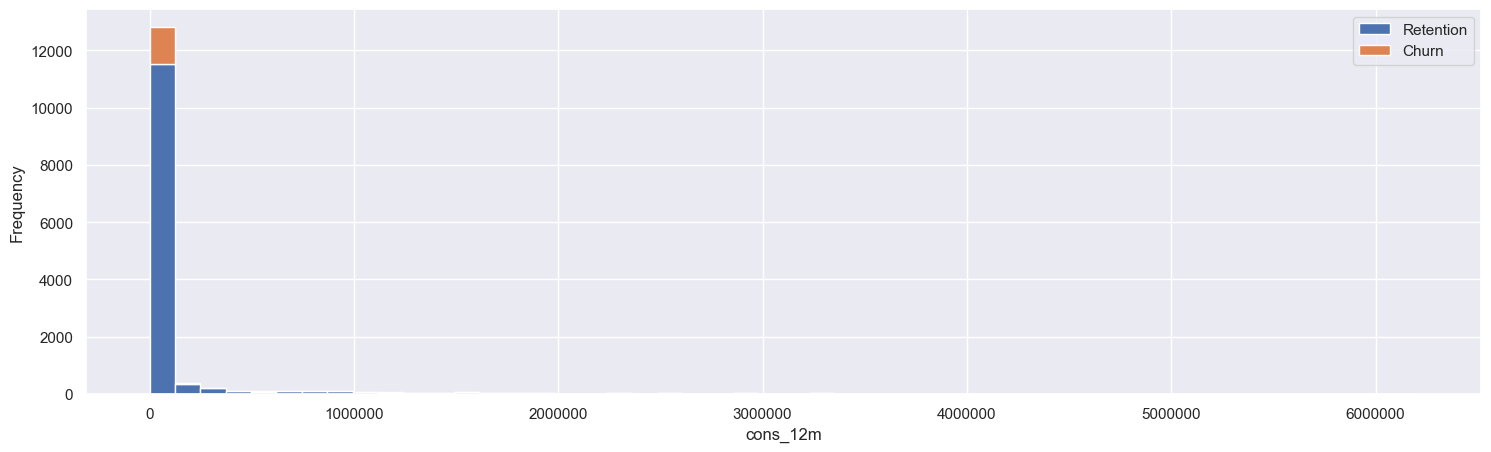

In [11]:
consumption = client_df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]

fig, axs = plt.subplots(nrows=1, figsize=(18, 5))

plot_distribution(consumption, 'cons_12m', axs)

In [3]:
from utils import plot_prob_progression

In [15]:
client_df['num_years_antig'].value_counts()

num_years_antig
6     4769
4     3982
3     2433
5     2317
7      509
11     185
12     110
8      103
9       92
10      81
13      13
2       11
1        1
Name: count, dtype: int64

d:\DS_Project\BCG_DataScience_VI\utils.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v = v.replace(bin_dict)
d:\DS_Project\BCG_DataScience_VI\utils.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['']+['(' + str(round(float(i.split(',')[0][1:]))) + ', ' + str(round(float(i.split(',')[1][:-1]))) + ']' for i in x_bins])


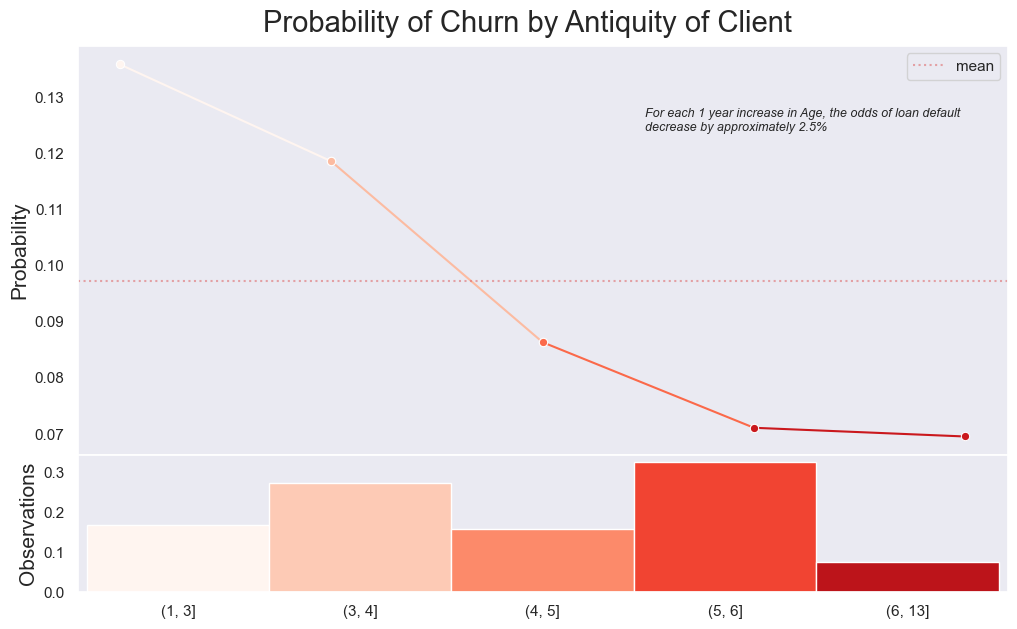

In [4]:
plot_prob_progression(client_df['num_years_antig'].dropna().reset_index(drop=True),
                      client_df['churn'].dropna().reset_index(drop=True),
                      x_intervals=6, use_quartiles=True,  mean_line=True,
                      title='Probability of Churn by Antiquity of Client',
                      text="For each 1 year increase in Age, the odds of churn\ndecrease by approximately 2.5%")
     

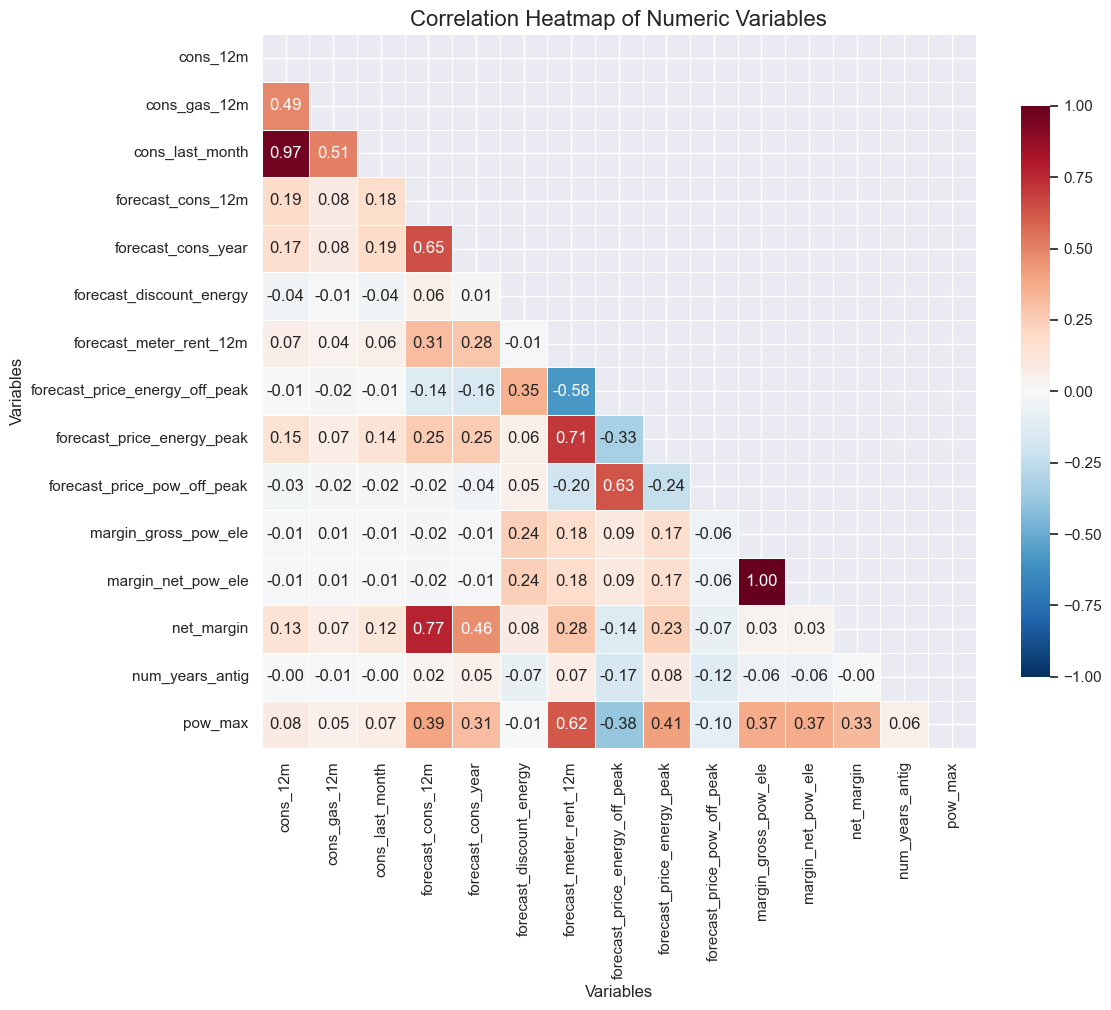

In [15]:
# Select numeric columns for correlation analysis
numeric_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
                   'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m',
                   'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
                   'forecast_price_pow_off_peak', 'margin_gross_pow_ele', 'margin_net_pow_ele',
                   'net_margin', 'num_years_antig', 'pow_max']

# Calculate the correlation matrix
corr_matrix = client_df[numeric_columns].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the figure size and create a subplot
plt.figure(figsize=(12, 10))
plt.subplot(1, 1, 1)

# Create the heatmap with customization
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Set the title and labels
plt.title('Correlation Heatmap of Numeric Variables', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()